## This notebook implements classification of Query Set using Cell Typist

In [4]:
import celltypist
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gseapy
import anndata as ad
import os 

In [5]:
os.chdir('..')
os.chdir('..')

In [6]:
os.getcwd()

'/Users/manuelsokolovr/Desktop/BrainSingleCellAnalysis'

In [7]:
reference = sc.read_h5ad("data/full_fetal_brain/h5ad/down_fullref.h5ad")

reference = reference[reference.obs['CellClass'].isin(['Radial glia', 'Glioblast', 'Oligo'])]

query0 = sc.read_h5ad("data/querys/unnorm_sc_C32_notreatment.h5ad")

query1 = sc.read_h5ad("data/querys/unnorm_sc_C32-24h.h5ad")

query2 = sc.read_h5ad("data/querys/unnorm_sc_C32-72h.h5ad")


query0.obs['CellClass'] = "0h"
query1.obs['CellClass'] = "24h"
query2.obs['CellClass'] = "72h"

## View UMAP Plot

         Falling back to preprocessing with `sc.pp.pca` and default params.


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
... storing 'CellClass' as categorical


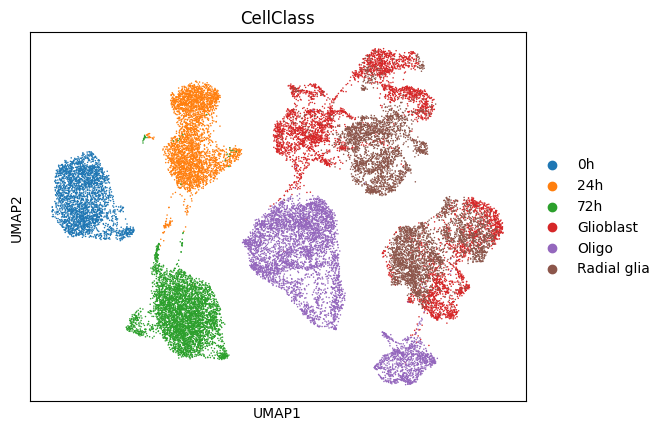

In [8]:
combined = ad.concat([reference, query0, query1, query2], join='outer')

sc.pp.normalize_total(combined, target_sum=1e4)
sc.pp.log1p(combined)

sc.pp.neighbors(combined)
sc.tl.umap(combined)
sc.pl.umap(combined, color='CellClass')

## Normalize before predictions

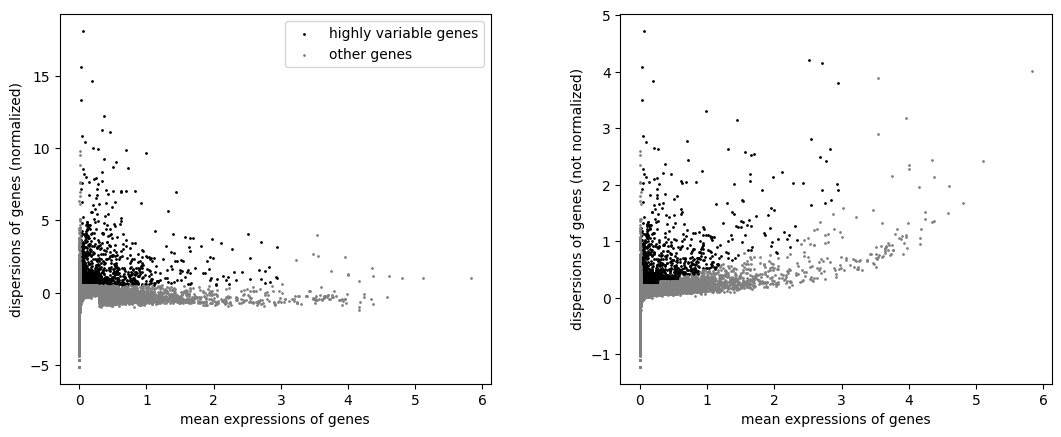

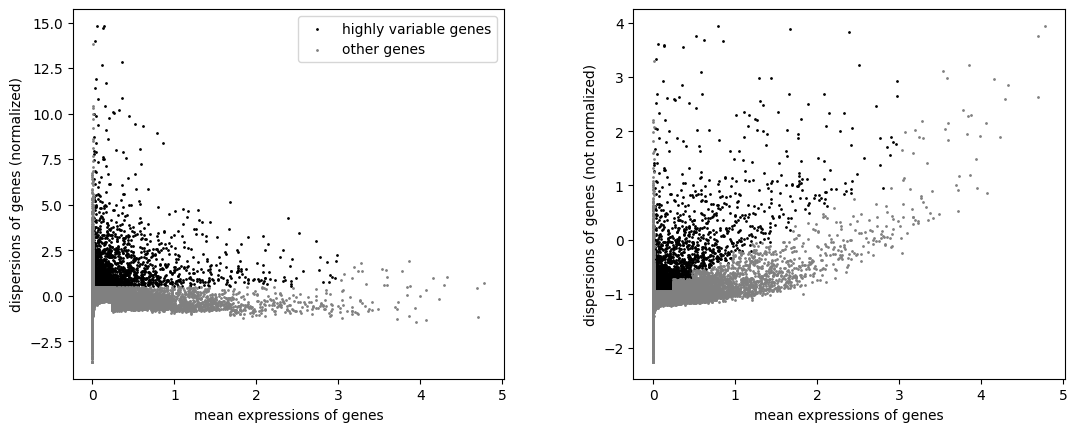

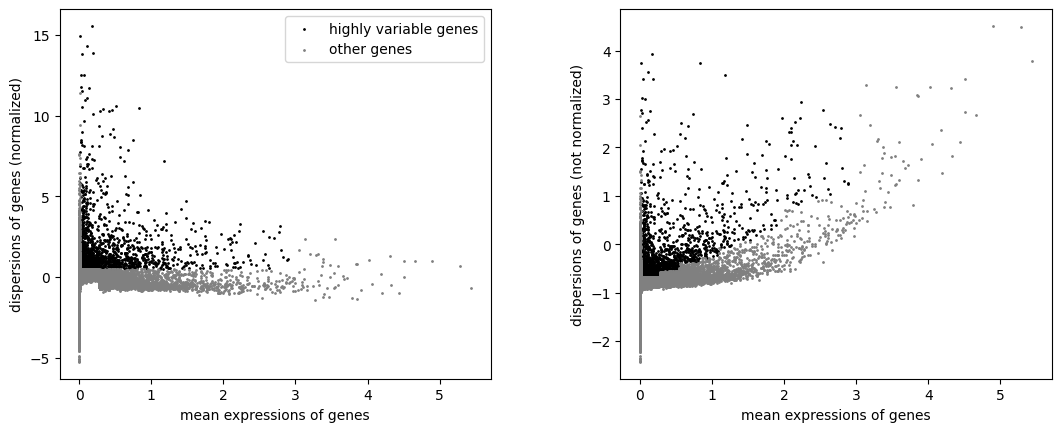

In [9]:
#query = query[:, query.var_names.isin(markers_list)]

sc.pp.normalize_total(query0, target_sum=1e4)
sc.pp.log1p(query0)
sc.pp.highly_variable_genes(query0, min_mean=0.0125, max_mean=3,min_disp=0.5)
sc.pl.highly_variable_genes(query0)


sc.pp.normalize_total(query1, target_sum=1e4)
sc.pp.log1p(query1)
sc.pp.highly_variable_genes(query1, min_mean=0.0125, max_mean=3,min_disp=0.5)
sc.pl.highly_variable_genes(query1)

sc.pp.normalize_total(query2, target_sum=1e4)
sc.pp.log1p(query2)
sc.pp.highly_variable_genes(query2, min_mean=0.0125, max_mean=3,min_disp=0.5)
sc.pl.highly_variable_genes(query2)


#reference = reference[:, reference.var_names.isin(markers_list)]
sc.pp.normalize_total(reference, target_sum=1e4)
sc.pp.log1p(reference)

In [10]:
model2 = celltypist.train(reference,labels = 'CellClass', n_jobs = 10,max_iter=1000, feature_selection = True)
prediction_query1= celltypist.annotate(query0, model = model2, majority_voting=True)
prediction_query2= celltypist.annotate(query1, model = model2, majority_voting=True)
prediction_query3 = celltypist.annotate(query2, model = model2, majority_voting=True)

adata_query1 = prediction_query1.to_adata()

adata_query2 = prediction_query2.to_adata()

adata_query3 = prediction_query3.to_adata()

🍳 Preparing data before training
✂️ 22025 non-expressed genes are filtered out
🔬 Input data has 15000 cells and 37455 genes
⚖️ Scaling input data
🏋️ Training data using SGD logistic regression
🔎 Selecting features
🧬 712 features are selected
🏋️ Starting the second round of training
🏋️ Training data using logistic regression
✅ Model training done!
🔬 Input data has 2732 cells and 36601 genes
🔗 Matching reference genes in the model
🧬 699 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!
🔬 Input data has 3300 cells and 36601 genes
🔗 Matching reference genes in the model
🧬 699 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Ov

... storing 'CellClass' as categorical


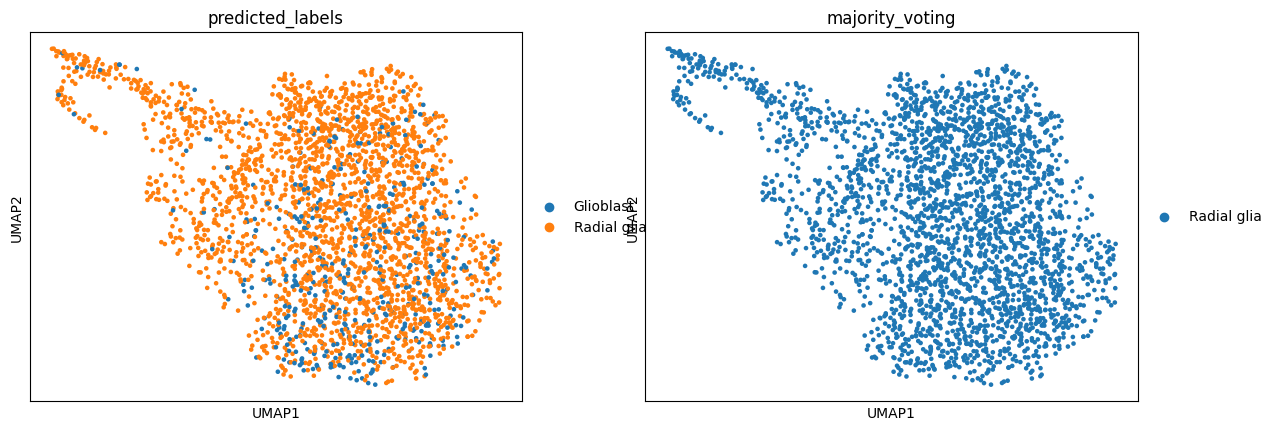

... storing 'CellClass' as categorical


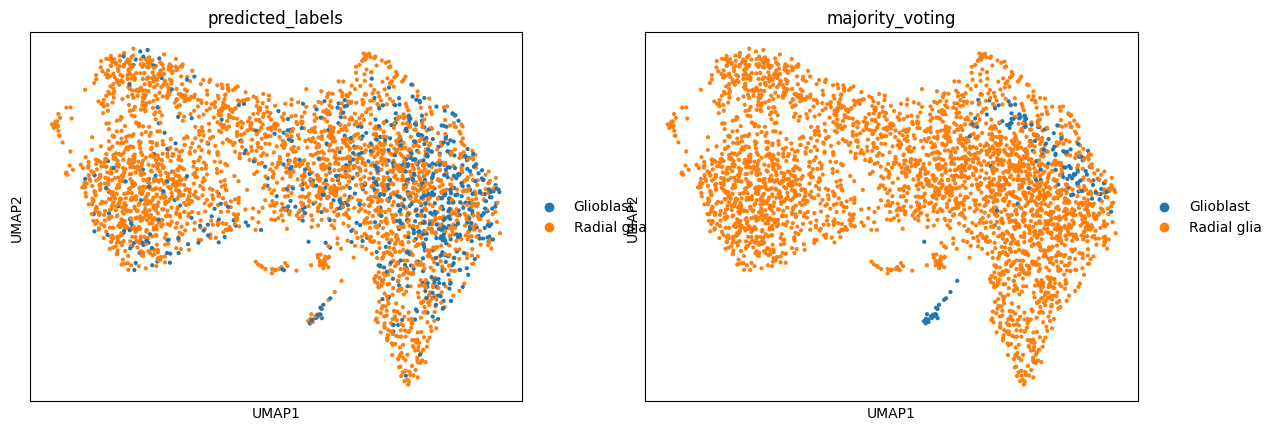

... storing 'CellClass' as categorical


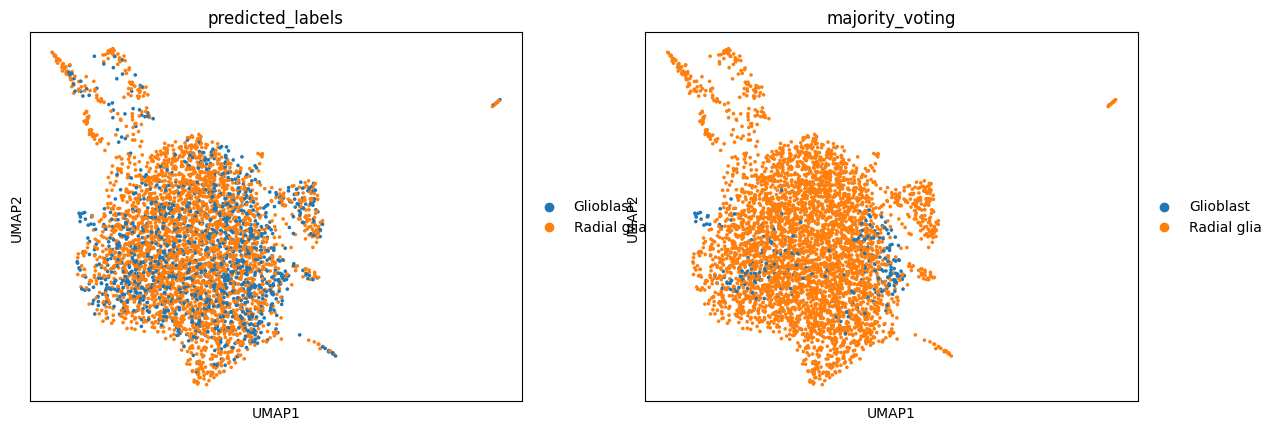

In [11]:
sc.tl.umap(adata_query1)
sc.pl.umap(adata_query1, color=["predicted_labels","majority_voting"])

sc.tl.umap(adata_query2)
sc.pl.umap(adata_query2, color=["predicted_labels","majority_voting"])


sc.tl.umap(adata_query3)
sc.pl.umap(adata_query3, color=["predicted_labels","majority_voting"])




From the plots above there might be low confidence scores associated with this classification ...

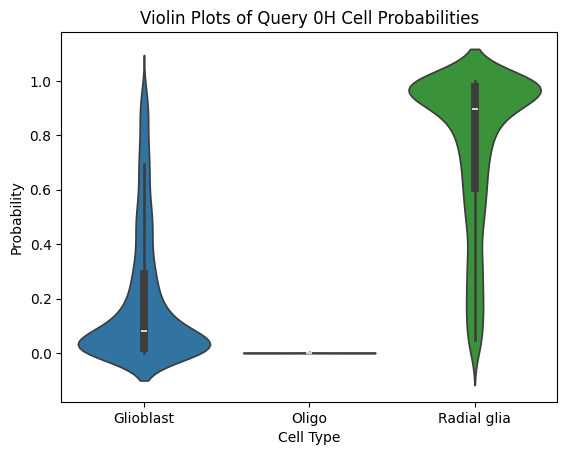

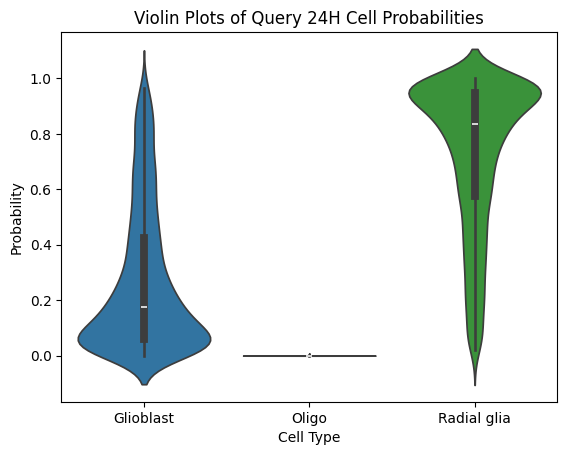

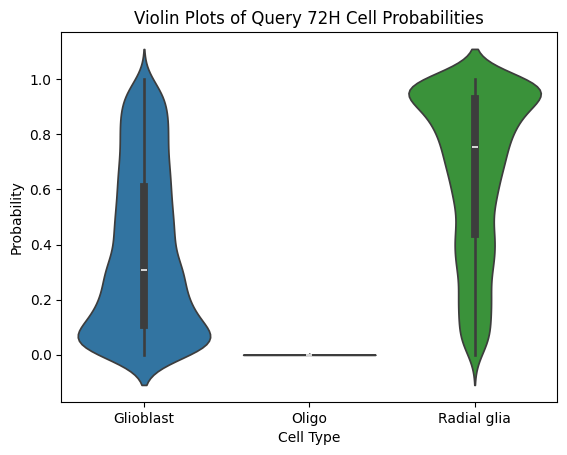

In [12]:
# Create a violin plot for each column in the same figure
plt.figure()

# Melt the DataFrame to a long format required for Seaborn's violin plot
# Plot
sns.violinplot(data=prediction_query1.probability_matrix)

# Customize plot
plt.title("Violin Plots of Query 0H Cell Probabilities")
plt.xlabel("Cell Type")
plt.ylabel("Probability")

# Show the plot
plt.show()


# Create a violin plot for each column in the same figure
plt.figure()

# Melt the DataFrame to a long format required for Seaborn's violin plot
# Plot
sns.violinplot(data=prediction_query2.probability_matrix)

# Customize plot
plt.title("Violin Plots of Query 24H Cell Probabilities")
plt.xlabel("Cell Type")
plt.ylabel("Probability")

# Show the plot
plt.show()

# Create a violin plot for each column in the same figure
plt.figure()

# Melt the DataFrame to a long format required for Seaborn's violin plot
# Plot
sns.violinplot(data=prediction_query3.probability_matrix)

# Customize plot
plt.title("Violin Plots of Query 72H Cell Probabilities")
plt.xlabel("Cell Type")
plt.ylabel("Probability")

# Show the plot
plt.show()

## Run multiple iterations of cell typist 
This step analysis if the classificatio of cell typist is stable for this specific case

In [13]:
predictions0h = pd.DataFrame()
predictions24h = pd.DataFrame()
predictions72h = pd.DataFrame()
predictions0h['id'] = list(query0.obs_names)
predictions24h['id'] = list(query1.obs_names)
predictions72h['id'] = list(query2.obs_names)

features =[]

for i in range(25):
    print(f"iteration{i}")
    model2 = celltypist.train(reference,labels = 'CellClass', max_iter=1000, n_jobs = 10, feature_selection = True)
    if i == 0:
        features = model2.features
    extracted = model2.features
    features = list(set(extracted) & set(features))  
    prediction_query0 = celltypist.annotate(query0, model = model2, majority_voting=True)
    prediction_query1 = celltypist.annotate(query1, model = model2, majority_voting=True)
    prediction_query2 = celltypist.annotate(query2, model = model2, majority_voting=True)
    predictions0h[f'run{i}'] = list(prediction_query0.predicted_labels.majority_voting)
    predictions24h[f'run{i}'] = list(prediction_query1.predicted_labels.majority_voting)
    predictions72h[f'run{i}'] = list(prediction_query2.predicted_labels.majority_voting)


🍳 Preparing data before training
✂️ 22025 non-expressed genes are filtered out
🔬 Input data has 15000 cells and 37455 genes
⚖️ Scaling input data


iteration0


🏋️ Training data using SGD logistic regression
🔎 Selecting features
🧬 748 features are selected
🏋️ Starting the second round of training
🏋️ Training data using logistic regression
✅ Model training done!
🔬 Input data has 2732 cells and 36601 genes
🔗 Matching reference genes in the model
🧬 726 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!
🔬 Input data has 3300 cells and 36601 genes
🔗 Matching reference genes in the model
🧬 726 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!
🔬 Input data 

iteration1


🏋️ Training data using SGD logistic regression
🔎 Selecting features
🧬 751 features are selected
🏋️ Starting the second round of training
🏋️ Training data using logistic regression
✅ Model training done!
🔬 Input data has 2732 cells and 36601 genes
🔗 Matching reference genes in the model
🧬 730 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!
🔬 Input data has 3300 cells and 36601 genes
🔗 Matching reference genes in the model
🧬 730 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!
🔬 Input data 

iteration2


✂️ 22025 non-expressed genes are filtered out
🔬 Input data has 15000 cells and 37455 genes
⚖️ Scaling input data
🏋️ Training data using SGD logistic regression
🔎 Selecting features
🧬 743 features are selected
🏋️ Starting the second round of training
🏋️ Training data using logistic regression
✅ Model training done!
🔬 Input data has 2732 cells and 36601 genes
🔗 Matching reference genes in the model
🧬 717 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!
🔬 Input data has 3300 cells and 36601 genes
🔗 Matching reference genes in the model
🧬 717 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-cluste

iteration3


✂️ 22025 non-expressed genes are filtered out
🔬 Input data has 15000 cells and 37455 genes
⚖️ Scaling input data
🏋️ Training data using SGD logistic regression
🔎 Selecting features
🧬 745 features are selected
🏋️ Starting the second round of training
🏋️ Training data using logistic regression
✅ Model training done!
🔬 Input data has 2732 cells and 36601 genes
🔗 Matching reference genes in the model
🧬 726 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!
🔬 Input data has 3300 cells and 36601 genes
🔗 Matching reference genes in the model
🧬 726 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-cluste

iteration4


✂️ 22025 non-expressed genes are filtered out
🔬 Input data has 15000 cells and 37455 genes
⚖️ Scaling input data
🏋️ Training data using SGD logistic regression
🔎 Selecting features
🧬 724 features are selected
🏋️ Starting the second round of training
🏋️ Training data using logistic regression
✅ Model training done!
🔬 Input data has 2732 cells and 36601 genes
🔗 Matching reference genes in the model
🧬 701 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!
🔬 Input data has 3300 cells and 36601 genes
🔗 Matching reference genes in the model
🧬 701 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-cluste

iteration5


✂️ 22025 non-expressed genes are filtered out
🔬 Input data has 15000 cells and 37455 genes
⚖️ Scaling input data
🏋️ Training data using SGD logistic regression
🔎 Selecting features
🧬 718 features are selected
🏋️ Starting the second round of training
🏋️ Training data using logistic regression
✅ Model training done!
🔬 Input data has 2732 cells and 36601 genes
🔗 Matching reference genes in the model
🧬 702 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!
🔬 Input data has 3300 cells and 36601 genes
🔗 Matching reference genes in the model
🧬 702 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-cluste

iteration6


🏋️ Training data using SGD logistic regression
🔎 Selecting features
🧬 754 features are selected
🏋️ Starting the second round of training
🏋️ Training data using logistic regression
✅ Model training done!
🔬 Input data has 2732 cells and 36601 genes
🔗 Matching reference genes in the model
🧬 726 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!
🔬 Input data has 3300 cells and 36601 genes
🔗 Matching reference genes in the model
🧬 726 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!
🔬 Input data 

iteration7


✂️ 22025 non-expressed genes are filtered out
🔬 Input data has 15000 cells and 37455 genes
⚖️ Scaling input data
🏋️ Training data using SGD logistic regression
🔎 Selecting features
🧬 745 features are selected
🏋️ Starting the second round of training
🏋️ Training data using logistic regression
✅ Model training done!
🔬 Input data has 2732 cells and 36601 genes
🔗 Matching reference genes in the model
🧬 727 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!
🔬 Input data has 3300 cells and 36601 genes
🔗 Matching reference genes in the model
🧬 727 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-cluste

iteration8


✂️ 22025 non-expressed genes are filtered out
🔬 Input data has 15000 cells and 37455 genes
⚖️ Scaling input data
🏋️ Training data using SGD logistic regression
🔎 Selecting features
🧬 716 features are selected
🏋️ Starting the second round of training
🏋️ Training data using logistic regression
✅ Model training done!
🔬 Input data has 2732 cells and 36601 genes
🔗 Matching reference genes in the model
🧬 698 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!
🔬 Input data has 3300 cells and 36601 genes
🔗 Matching reference genes in the model
🧬 698 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-cluste

iteration9


🏋️ Training data using SGD logistic regression
🔎 Selecting features
🧬 739 features are selected
🏋️ Starting the second round of training
🏋️ Training data using logistic regression
✅ Model training done!
🔬 Input data has 2732 cells and 36601 genes
🔗 Matching reference genes in the model
🧬 723 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!
🔬 Input data has 3300 cells and 36601 genes
🔗 Matching reference genes in the model
🧬 723 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!
🔬 Input data 

iteration10


🏋️ Training data using SGD logistic regression
🔎 Selecting features
🧬 752 features are selected
🏋️ Starting the second round of training
🏋️ Training data using logistic regression
✅ Model training done!
🔬 Input data has 2732 cells and 36601 genes
🔗 Matching reference genes in the model
🧬 731 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!
🔬 Input data has 3300 cells and 36601 genes
🔗 Matching reference genes in the model
🧬 731 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!
🔬 Input data 

iteration11


🏋️ Training data using SGD logistic regression
🔎 Selecting features
🧬 715 features are selected
🏋️ Starting the second round of training
🏋️ Training data using logistic regression
✅ Model training done!
🔬 Input data has 2732 cells and 36601 genes
🔗 Matching reference genes in the model
🧬 698 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!
🔬 Input data has 3300 cells and 36601 genes
🔗 Matching reference genes in the model
🧬 698 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!
🔬 Input data 

iteration12


🏋️ Training data using SGD logistic regression
🔎 Selecting features
🧬 755 features are selected
🏋️ Starting the second round of training
🏋️ Training data using logistic regression
✅ Model training done!
🔬 Input data has 2732 cells and 36601 genes
🔗 Matching reference genes in the model
🧬 725 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!
🔬 Input data has 3300 cells and 36601 genes
🔗 Matching reference genes in the model
🧬 725 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!
🔬 Input data 

iteration13


🏋️ Training data using SGD logistic regression
🔎 Selecting features
🧬 752 features are selected
🏋️ Starting the second round of training
🏋️ Training data using logistic regression
✅ Model training done!
🔬 Input data has 2732 cells and 36601 genes
🔗 Matching reference genes in the model
🧬 735 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!
🔬 Input data has 3300 cells and 36601 genes
🔗 Matching reference genes in the model
🧬 735 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!
🔬 Input data 

iteration14


🏋️ Training data using SGD logistic regression
🔎 Selecting features
🧬 742 features are selected
🏋️ Starting the second round of training
🏋️ Training data using logistic regression
✅ Model training done!
🔬 Input data has 2732 cells and 36601 genes
🔗 Matching reference genes in the model
🧬 718 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!
🔬 Input data has 3300 cells and 36601 genes
🔗 Matching reference genes in the model
🧬 718 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!
🔬 Input data 

iteration15


🏋️ Training data using SGD logistic regression
🔎 Selecting features
🧬 740 features are selected
🏋️ Starting the second round of training
🏋️ Training data using logistic regression
✅ Model training done!
🔬 Input data has 2732 cells and 36601 genes
🔗 Matching reference genes in the model
🧬 721 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!
🔬 Input data has 3300 cells and 36601 genes
🔗 Matching reference genes in the model
🧬 721 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!
🔬 Input data 

iteration16


🏋️ Training data using SGD logistic regression
🔎 Selecting features
🧬 740 features are selected
🏋️ Starting the second round of training
🏋️ Training data using logistic regression
✅ Model training done!
🔬 Input data has 2732 cells and 36601 genes
🔗 Matching reference genes in the model
🧬 724 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!
🔬 Input data has 3300 cells and 36601 genes
🔗 Matching reference genes in the model
🧬 724 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!
🔬 Input data 

iteration17


🏋️ Training data using SGD logistic regression
🔎 Selecting features
🧬 743 features are selected
🏋️ Starting the second round of training
🏋️ Training data using logistic regression
✅ Model training done!
🔬 Input data has 2732 cells and 36601 genes
🔗 Matching reference genes in the model
🧬 726 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!
🔬 Input data has 3300 cells and 36601 genes
🔗 Matching reference genes in the model
🧬 726 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!
🔬 Input data 

iteration18


🏋️ Training data using SGD logistic regression
🔎 Selecting features
🧬 747 features are selected
🏋️ Starting the second round of training
🏋️ Training data using logistic regression
✅ Model training done!
🔬 Input data has 2732 cells and 36601 genes
🔗 Matching reference genes in the model
🧬 726 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!
🔬 Input data has 3300 cells and 36601 genes
🔗 Matching reference genes in the model
🧬 726 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!
🔬 Input data 

iteration19


🏋️ Training data using SGD logistic regression
🔎 Selecting features
🧬 735 features are selected
🏋️ Starting the second round of training
🏋️ Training data using logistic regression
✅ Model training done!
🔬 Input data has 2732 cells and 36601 genes
🔗 Matching reference genes in the model
🧬 711 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!
🔬 Input data has 3300 cells and 36601 genes
🔗 Matching reference genes in the model
🧬 711 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!
🔬 Input data 

iteration20


🏋️ Training data using SGD logistic regression
🔎 Selecting features
🧬 743 features are selected
🏋️ Starting the second round of training
🏋️ Training data using logistic regression
✅ Model training done!
🔬 Input data has 2732 cells and 36601 genes
🔗 Matching reference genes in the model
🧬 723 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!
🔬 Input data has 3300 cells and 36601 genes
🔗 Matching reference genes in the model
🧬 723 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!
🔬 Input data 

iteration21


🏋️ Training data using SGD logistic regression
🔎 Selecting features
🧬 759 features are selected
🏋️ Starting the second round of training
🏋️ Training data using logistic regression
✅ Model training done!
🔬 Input data has 2732 cells and 36601 genes
🔗 Matching reference genes in the model
🧬 732 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!
🔬 Input data has 3300 cells and 36601 genes
🔗 Matching reference genes in the model
🧬 732 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!
🔬 Input data 

iteration22


🏋️ Training data using SGD logistic regression
🔎 Selecting features
🧬 747 features are selected
🏋️ Starting the second round of training
🏋️ Training data using logistic regression
✅ Model training done!
🔬 Input data has 2732 cells and 36601 genes
🔗 Matching reference genes in the model
🧬 728 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!
🔬 Input data has 3300 cells and 36601 genes
🔗 Matching reference genes in the model
🧬 728 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!
🔬 Input data 

iteration23


🏋️ Training data using SGD logistic regression
🔎 Selecting features
🧬 731 features are selected
🏋️ Starting the second round of training
🏋️ Training data using logistic regression
✅ Model training done!
🔬 Input data has 2732 cells and 36601 genes
🔗 Matching reference genes in the model
🧬 714 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!
🔬 Input data has 3300 cells and 36601 genes
🔗 Matching reference genes in the model
🧬 714 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!
🔬 Input data 

iteration24


🏋️ Training data using SGD logistic regression
🔎 Selecting features
🧬 715 features are selected
🏋️ Starting the second round of training
🏋️ Training data using logistic regression
✅ Model training done!
🔬 Input data has 2732 cells and 36601 genes
🔗 Matching reference genes in the model
🧬 696 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!
🔬 Input data has 3300 cells and 36601 genes
🔗 Matching reference genes in the model
🧬 696 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!
🔬 Input data 

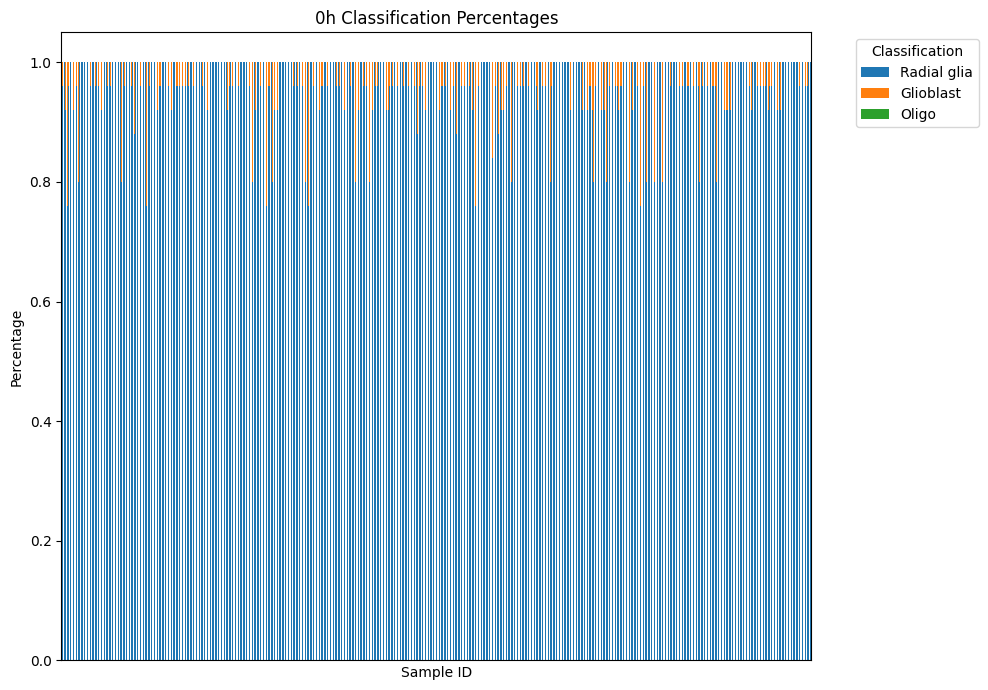

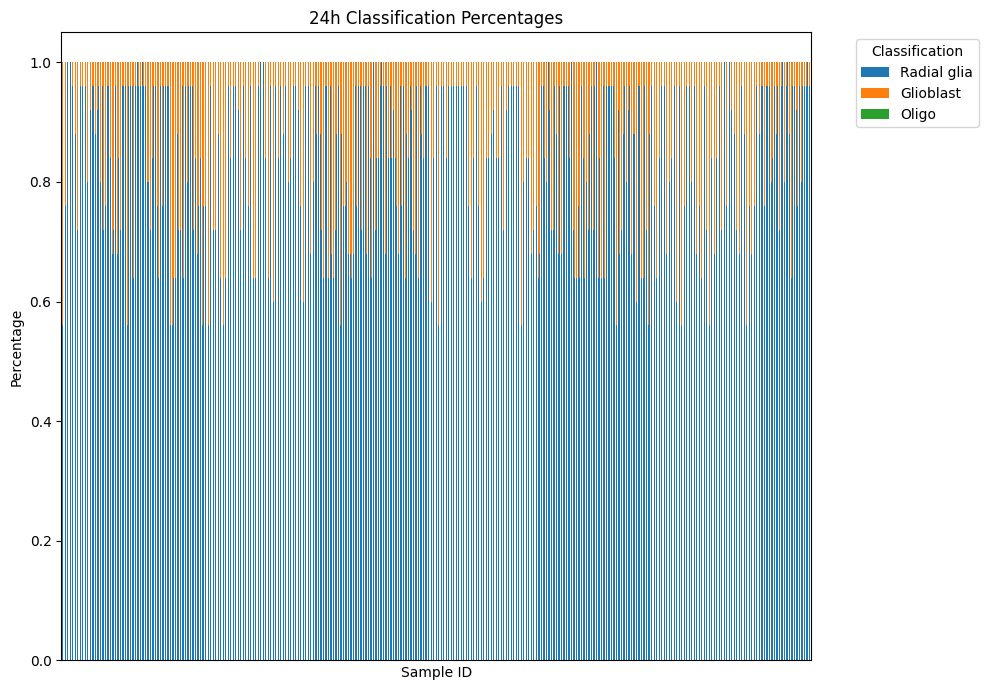

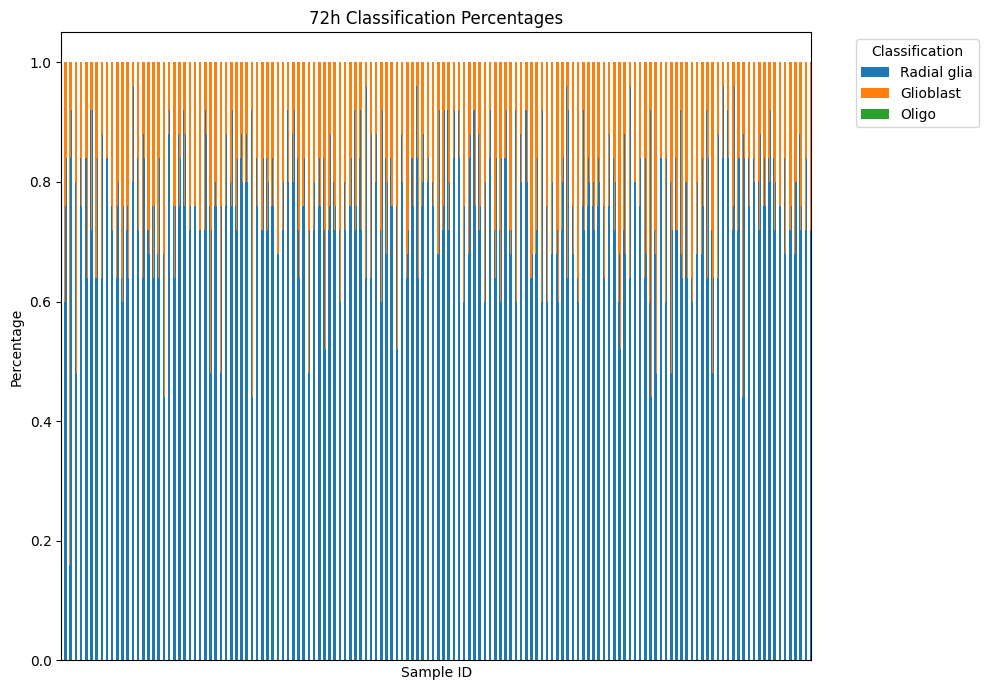

In [14]:
# Function to calculate the percentage of each classification for each id
def calculate_percentage(predictions):
    ids = predictions['id']
    runs = predictions.drop(columns=['id'])
    unique_labels = ["Radial glia", "Glioblast", "Oligo"]
    percentage_df = pd.DataFrame(0, index=ids, columns=unique_labels)

    for index, row in runs.iterrows():
        for label in row:
            percentage_df.at[predictions.at[index, 'id'], label] += 1
    
    percentage_df = percentage_df.div(len(runs.columns))
    return percentage_df

# Calculate percentage for both predictions24h and predictions72h
percentage_0h = calculate_percentage(predictions0h)
percentage_24h = calculate_percentage(predictions24h)
percentage_72h = calculate_percentage(predictions72h)

# Updated plotting function for stacked bar plots
def plot_stacked_bar(percentage_df, title):
    ax = percentage_df.plot(kind='bar', stacked=True, figsize=(10, 7))
    ax.set_ylabel('Percentage')
    ax.set_title(title)
    plt.xlabel('Sample ID')
    plt.xticks([], rotation=45, ha='right')  # Removing x-axis labels
    plt.legend(title='Classification', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# Plot for 24h
plot_stacked_bar(percentage_0h, '0h Classification Percentages')
plot_stacked_bar(percentage_24h, '24h Classification Percentages')
plot_stacked_bar(percentage_72h, '72h Classification Percentages')

In [16]:
def calculate_majority(row):
    return row.value_counts().idxmax()

# Create 'majority' column for predictions24h and predictions72h
predictions0h['majority_voting'] = predictions0h.apply(calculate_majority, axis=1)
predictions24h['majority_voting'] = predictions24h.apply(calculate_majority, axis=1)
predictions72h['majority_voting'] = predictions72h.apply(calculate_majority, axis=1)

... storing 'majority_voting' as categorical


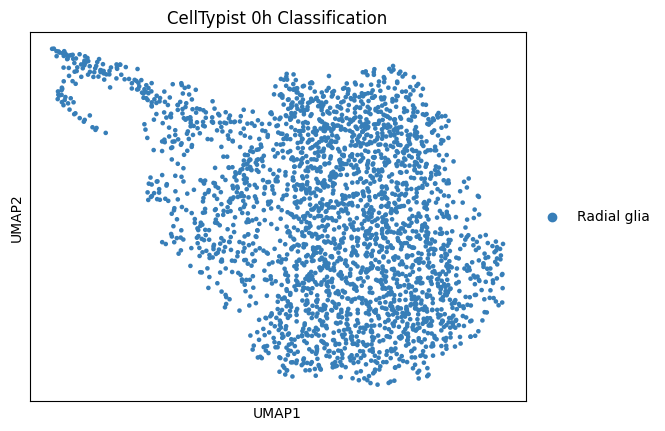

... storing 'majority_voting' as categorical


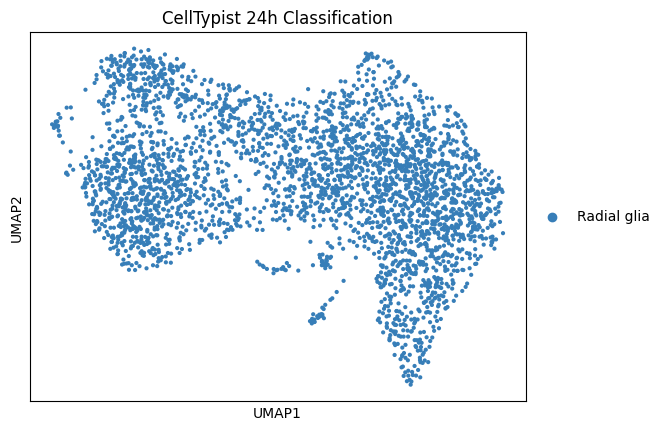

... storing 'majority_voting' as categorical


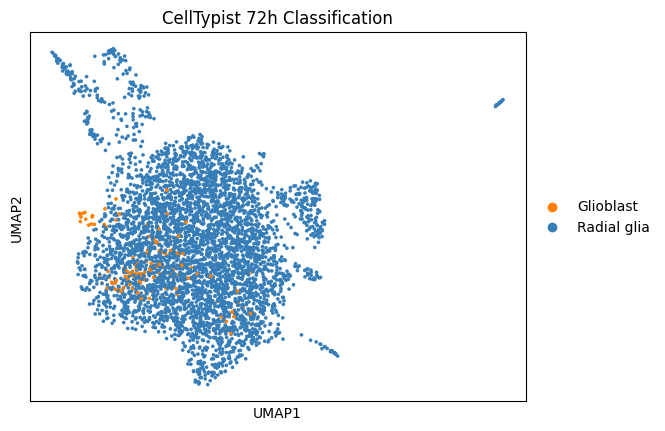

In [17]:
query0 = prediction_query0.to_adata()
query1 = prediction_query1.to_adata()
query2 = prediction_query2.to_adata()

custom_colors = {'Radial glia': '#377eb8',  # Blue
                 'Glioblast': '#ff7f00',   # Orange
                 'Oligo': '#4daf4a'}  


query0.obs['majority_voting'] = list(predictions0h['majority_voting'])
query1.obs['majority_voting'] = list(predictions24h['majority_voting'])
query2.obs['majority_voting'] = list(predictions72h['majority_voting'])

sc.pl.umap(query0, color = ['majority_voting'], palette=custom_colors, title='CellTypist 0h Classification')
sc.pl.umap(query1, color = ['majority_voting'], palette=custom_colors, title='CellTypist 24h Classification')
sc.pl.umap(query2, color = ['majority_voting'], palette=custom_colors, title='CellTypist 72h Classification')